In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge



In [18]:
data = pd.read_csv('./dataset/qa_va_content_rag.csv')
data = data.dropna(subset=['content', 'basic_llm', 'rag_llm'])

data.head()

,Unnamed: 0.1,Unnamed: 0,source_url,title,content,index,question,answer,basic_llm,basic_time,rag_llm,rag_time,rag_similarity,rag_rerank_llm,rag_rerank_time,rag_rerank_similarity
0,0,0,https://www.va.gov/disability/after-you-file-c...,The VA claim process after you file your claim...,Learn about what happens after you file your c...,0,What is the average number of days it takes to...,The average number of days it takes to process...,The average number of days it takes to process...,12.445703,147.2 days,17.371511,Title: https://www.va.gov/disability/after-you...,The average number of days it takes to process...,1.771228,Title: https://www.va.gov/disability/after-you...
1,1,1,https://www.va.gov/disability/after-you-file-c...,How long does it take VA to make a decision?. ...,147.2 days Average number of days to complete ...,1,What is the average number of days it takes fo...,The average number of days it takes for the VA...,The average number of days it takes for VA to ...,12.905303,147,13.435543,Title: https://www.va.gov/disability/after-you...,The average number of days it takes for VA to ...,1.275033,Title: https://www.va.gov/disability/after-you...
2,2,2,https://www.va.gov/disability/after-you-file-c...,The time it takes to review your claim depends...,The time it takes to review your claim depends...,2,What factors affect the time it takes to revie...,The time it takes to review a claim for disabi...,The time it takes to review a claim for disabi...,35.227360,"The type of claim you filed, how many injuries...",32.196040,Title: https://www.va.gov/disability/after-you...,The time it takes to review a claim for disabi...,2.184501,Title: https://www.va.gov/disability/after-you...
3,3,3,https://www.va.gov/disability/after-you-file-c...,What should I do while I wait?. disability aft...,You don’t need to do anything unless we send y...,3,What should you do while waiting for a disabil...,While waiting for a disability claim after fil...,The best thing to do while waiting for a disab...,39.914326,The answer to this question is based on the pr...,67.983859,Title: https://www.va.gov/disability/after-you...,While waiting for a disability claim after fil...,2.891744,Title: https://www.va.gov/disability/after-you...
4,4,4,https://www.va.gov/disability/after-you-file-c...,What happens after I file a VA disability clai...,Claim received We’ll let you know when we rece...,4,What are the steps involved in the process aft...,"After filing a VA disability claim, the first ...",The steps involved in the process after filing...,85.216858,The steps involved in the process after filing...,24.199235,Title: https://www.va.gov/disability/after-you...,"After filing a VA disability claim, the follow...",7.849523,Title: https://www.va.gov/disability/after-you...


In [20]:

rouge = Rouge()
smoothing_function = SmoothingFunction().method4

# Function to calculate BLEU score
def calculate_bleu(reference, hypothesis):
    reference = reference.split()
    hypothesis = hypothesis.split()
    return sentence_bleu([reference], hypothesis, smoothing_function=smoothing_function)

# Function to calculate exact match accuracy
def calculate_exact_match(reference, hypothesis):
    return int(reference.strip().lower() == hypothesis.strip().lower())



In [21]:

results = {
    'LLaMA': {'exact_match': [], 'bleu': [], 'rouge': []},
    'RAG_LLaMA': {'exact_match': [], 'bleu': [], 'rouge': []},
    'RAG_LLaMA_Rerank': {'exact_match': [], 'bleu': [], 'rouge': []},
}


for index, row in data.iterrows():
    gt_answer = row['content']
    llama_answer = row['basic_llm']
    rag_llama_answer = row['rag_llm']
    rag_rerank_answer = row['rag_rerank_llm']
    
    # LLaMA
    results['LLaMA']['exact_match'].append(calculate_exact_match(gt_answer, llama_answer))
    results['LLaMA']['bleu'].append(calculate_bleu(gt_answer, llama_answer))
    results['LLaMA']['rouge'].append(rouge.get_scores(llama_answer, gt_answer)[0]['rouge-l']['f'])
    
    # RAG LLaMA
    results['RAG_LLaMA']['exact_match'].append(calculate_exact_match(gt_answer, rag_llama_answer))
    results['RAG_LLaMA']['bleu'].append(calculate_bleu(gt_answer, rag_llama_answer))
    results['RAG_LLaMA']['rouge'].append(rouge.get_scores(rag_llama_answer, gt_answer)[0]['rouge-l']['f'])
    
    # RAG LLaMA with Reranking
    results['RAG_LLaMA_Rerank']['exact_match'].append(calculate_exact_match(gt_answer, rag_rerank_answer))
    results['RAG_LLaMA_Rerank']['bleu'].append(calculate_bleu(gt_answer, rag_rerank_answer))
    results['RAG_LLaMA_Rerank']['rouge'].append(rouge.get_scores(rag_rerank_answer, gt_answer)[0]['rouge-l']['f'])

# Calculate average metrics
summary = {
    'LLaMA': {
        'exact_match_accuracy': sum(results['LLaMA']['exact_match']) / len(results['LLaMA']['exact_match']),
        'average_bleu': sum(results['LLaMA']['bleu']) / len(results['LLaMA']['bleu']),
        'average_rouge': sum(results['LLaMA']['rouge']) / len(results['LLaMA']['rouge']),
    },
    'RAG_LLaMA': {
        'exact_match_accuracy': sum(results['RAG_LLaMA']['exact_match']) / len(results['RAG_LLaMA']['exact_match']),
        'average_bleu': sum(results['RAG_LLaMA']['bleu']) / len(results['RAG_LLaMA']['bleu']),
        'average_rouge': sum(results['RAG_LLaMA']['rouge']) / len(results['RAG_LLaMA']['rouge']),
    },
    'RAG_LLaMA_Rerank': {
        'exact_match_accuracy': sum(results['RAG_LLaMA_Rerank']['exact_match']) / len(results['RAG_LLaMA_Rerank']['exact_match']),
        'average_bleu': sum(results['RAG_LLaMA_Rerank']['bleu']) / len(results['RAG_LLaMA_Rerank']['bleu']),
        'average_rouge': sum(results['RAG_LLaMA_Rerank']['rouge']) / len(results['RAG_LLaMA_Rerank']['rouge']),
    },
}

# Display summary results
for method, metrics in summary.items():
    print(f"Method: {method}")
    print(f"  Exact Match Accuracy: {metrics['exact_match_accuracy']:.2f}")
    print(f"  Average BLEU Score: {metrics['average_bleu']:.2f}")
    print(f"  Average ROUGE-L Score: {metrics['average_rouge']:.2f}\n")


Method: LLaMA
  Exact Match Accuracy: 0.00
  Average BLEU Score: 0.05
  Average ROUGE-L Score: 0.25

Method: RAG_LLaMA
  Exact Match Accuracy: 0.03
  Average BLEU Score: 0.21
  Average ROUGE-L Score: 0.45

Method: RAG_LLaMA_Rerank
  Exact Match Accuracy: 0.00
  Average BLEU Score: 0.21
  Average ROUGE-L Score: 0.48



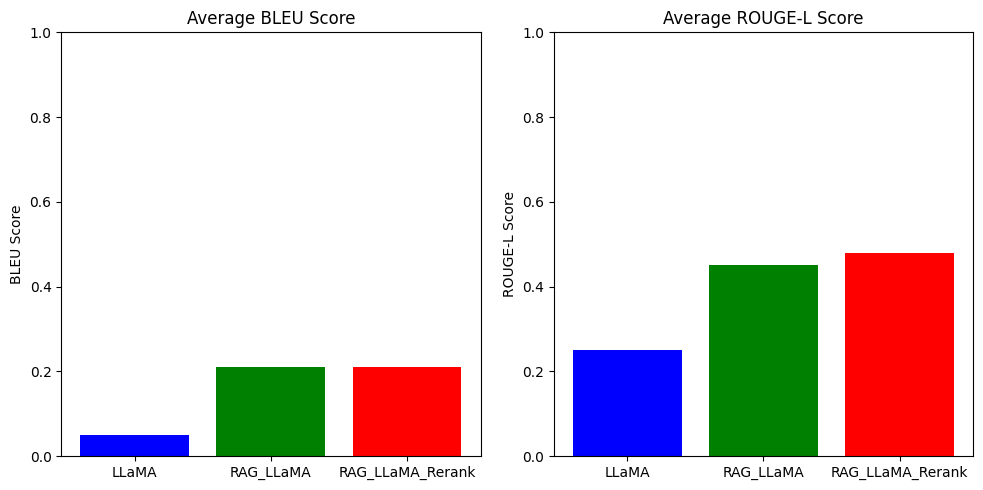

In [24]:
import matplotlib.pyplot as plt
import numpy as np

methods = ['LLaMA', 'RAG_LLaMA', 'RAG_LLaMA_Rerank']
average_bleu_score = [0.05, 0.21, 0.21]
average_rouge_l_score = [0.25, 0.45, 0.48]


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Average BLEU Score plot
axs[0].bar(methods, average_bleu_score, color=['blue', 'green', 'red'])
axs[0].set_title('Average BLEU Score')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('BLEU Score')

# Average ROUGE-L Score plot
axs[1].bar(methods, average_rouge_l_score, color=['blue', 'green', 'red'])
axs[1].set_title('Average ROUGE-L Score')
axs[1].set_ylim(0, 1)
axs[1].set_ylabel('ROUGE-L Score')

# Show plot
plt.tight_layout()
plt.show()
